# Finetune VGG16


With 224x224 silence-removed melspectrogram images without data augmentation


In [1]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import time

In [2]:
# Get the absolute path to the project root without relying on __file__
notebook_path = os.getcwd()  # Gets current working directory
project_root = os.path.abspath(os.path.join(notebook_path, "../.."))
sys.path.insert(0, project_root)

In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

2.5.1+cu121
True


Set the seed for reproducability


In [4]:
random_seed = 42

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

if (torch.cuda.is_available()):
    torch.cuda.manual_seed(random_seed)

Set some constant strings


In [5]:
FINETUNED_MODEL = 'vgg16_224silence'

train_csv = '../../../data/melspectrogram_train_dataset.csv'
test_csv = '../../../data/melspectrogram_test_dataset.csv'
val_csv = '../../../data/melspectrogram_val_dataset.csv'
root_dir = '../../../data/'
class_weights_path = '../../../data/class_weights.pt'

Custom dataset class for loading the mel spectrogram images


In [6]:
from datasets.MelspectrogramDataset import MelSpectrogramDataset

Define the training function


In [7]:
def train(model, trainloader, criterion, optimizer, device):
    train_loss = 0.0
    train_total = 0
    train_correct = 0

    # train mode
    model.train()

    epoch_start = time.time()
    pbar = tqdm(enumerate(trainloader), total=len(
        trainloader), desc="Training")

    for i, (inputs, labels) in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update training loss
        train_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        # Calculate time metrics
        elapsed = time.time() - epoch_start
        progress = (i + 1) / len(trainloader)
        eta = elapsed / progress - elapsed

        # Update progress bar with current loss and ETA
        pbar.set_postfix({
            "Loss": f"{loss.item()}",
            "Elapsed": f"{elapsed:.4f}s",
            "ETA": f"{eta:.4f}s"
        })

    train_loss = train_loss / len(trainloader)
    train_accuracy = train_correct / train_total * 100

    return model, train_loss, train_accuracy

Define the validation function


In [8]:
def validate(model, valloader, criterion, device):
    val_loss = 0.0
    val_total = 0
    val_correct = 0

    # Switch to evaluation mode
    model.eval()

    epoch_start = time.time()
    pbar = tqdm(enumerate(valloader), total=len(
        valloader), desc="Validating")

    with torch.no_grad():
        for i, (inputs, labels) in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Update test loss
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            # Calculate time metrics
            elapsed = time.time() - epoch_start
            progress = (i + 1) / len(valloader)
            eta = elapsed / progress - elapsed

            # Update progress bar with current loss and ETA
            pbar.set_postfix({
                "Loss": f"{loss.item()}",
                "Elapsed": f"{elapsed:.4f}s",
                "ETA": f"{eta:.4f}s"
            })

    val_loss = val_loss / len(valloader)
    val_accuracy = val_correct / val_total * 100

    return val_loss, val_accuracy

Define what happens in each epoch


In [9]:
def train_epochs(model, trainloader, valloader, criterion, optimizer, device, num_epochs):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    best_accuracy = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        epoch_start = time.time()

        model, train_loss, train_accuracy = train(
            model, trainloader, criterion, optimizer, device)
        val_loss, val_accuracy = validate(
            model, valloader, criterion, device)

        epoch_elapsed = time.time() - epoch_start
        print(f"Epoch {epoch+1} completed in {epoch_elapsed:.4f}s")
        print(f'Train Loss: {train_loss} - Train Accuracy: {train_accuracy}')
        print(
            f'Validation Loss: {val_loss} - Validation Accuracy: {val_accuracy}')
        print()

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Check if current model is best performing using test_accuracy
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), f'best_{FINETUNED_MODEL}.pt')
            checkpoint = {
                'epoch': epoch + 1,
                'train_losses': train_losses,
                'train_accuracies': train_accuracies,
                'val_losses': val_losses,
                'val_accuracies': val_accuracies,
            }
            torch.save(checkpoint, f'best_{FINETUNED_MODEL}_checkpoint.pt')

    return model, train_losses, train_accuracies, val_losses, val_accuracies

Plot the loss and accuracy graphs


In [10]:
def plot_loss(train_losses, val_losses):
    plt.figure()
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
    plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [11]:
def plot_accuracy(train_accuracies, val_accuracies):
    plt.figure()
    plt.plot(range(len(train_accuracies)),
             train_accuracies, label='Training Accuracy')
    plt.plot(range(len(val_accuracies)),
             val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Define the model


In [12]:
model = models.vgg16(pretrained=True)

c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Prepare for fine-tuning


In [13]:
# Number of classes
num_classes = 9

# Freeze all layers except the last fully connected layer
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

# Modify final fully connected layer according to number of classes
num_features = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(num_features, num_classes)
# print("Modified model")
# print(model)

# Unfreeze the final fully connected layer so it will be trained
for param in model.classifier[-1].parameters():
    param.requires_grad = True

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Define the learning rate, criterion, optimizer, transformations, and number of epochs


In [14]:
learning_rate = 0.001

class_weights = torch.load(class_weights_path).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),          # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                         0.229, 0.224, 0.225])  # Normalize to ImageNet stats
])

epochs = 20

C:\Users\profi\AppData\Local\Temp\ipykernel_6468\29953048.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  class_weights = torch.load(class_weights_path).to(device)


Execute the fine-tuning


Mapping from Emotion to Number: {'Anger': 0, 'Bored': 1, 'Disgust': 2, 'Fear': 3, 'Happy': 4, 'Neutral': 5, 'Question': 6, 'Sad': 7, 'Surprise': 8}
Model is on: cuda:0
Epoch 1/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.96it/s, Loss=0.856153666973114, Elapsed=25.8994s, ETA=0.0000s]  


Epoch 1 completed in 104.6905s
Train Loss: 1.479204870717374 - Train Accuracy: 37.21308880396192
Validation Loss: 1.2943427713712057 - Validation Accuracy: 41.89531447868299

Epoch 2/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.96it/s, Loss=0.6770507097244263, Elapsed=25.7425s, ETA=0.0000s] 


Epoch 2 completed in 103.0011s
Train Loss: 1.3929297734547212 - Train Accuracy: 40.2930734266525
Validation Loss: 1.2796735509236654 - Validation Accuracy: 44.628535246939634

Epoch 3/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.94it/s, Loss=1.020936369895935, Elapsed=25.9092s, ETA=0.0000s]  


Epoch 3 completed in 103.1422s
Train Loss: 1.3807828161068734 - Train Accuracy: 40.61192646027905
Validation Loss: 1.2473857831954955 - Validation Accuracy: 46.38032925284931

Epoch 4/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.96it/s, Loss=0.8959969878196716, Elapsed=25.7098s, ETA=0.0000s] 


Epoch 4 completed in 102.7407s
Train Loss: 1.37259130222949 - Train Accuracy: 41.4915990140431
Validation Loss: 1.2330704267819723 - Validation Accuracy: 42.98227100042212

Epoch 5/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.97it/s, Loss=0.9603166580200195, Elapsed=25.7465s, ETA=0.0000s] 


Epoch 5 completed in 102.6831s
Train Loss: 1.3762516193307204 - Train Accuracy: 41.4554171095181
Validation Loss: 1.2664709059397379 - Validation Accuracy: 43.78429717180245

Epoch 6/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.94it/s, Loss=1.0021919012069702, Elapsed=25.8696s, ETA=0.0000s] 


Epoch 6 completed in 102.8321s
Train Loss: 1.375631762722324 - Train Accuracy: 41.34234865787748
Validation Loss: 1.2230129623413086 - Validation Accuracy: 45.12452511608274

Epoch 7/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.88it/s, Loss=0.9035969972610474, Elapsed=26.1080s, ETA=0.0000s] 


Epoch 7 completed in 103.0283s
Train Loss: 1.379289913039676 - Train Accuracy: 41.02123425521811
Validation Loss: 1.2514772335688273 - Validation Accuracy: 44.18531025749261

Epoch 8/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.98it/s, Loss=0.9015693068504333, Elapsed=25.7842s, ETA=0.0000s] 


Epoch 8 completed in 102.6337s
Train Loss: 1.3630604499337302 - Train Accuracy: 41.733565500554036
Validation Loss: 1.2556250723203024 - Validation Accuracy: 42.87674124102997

Epoch 9/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.93it/s, Loss=0.8419391512870789, Elapsed=25.7632s, ETA=0.0000s] 


Epoch 9 completed in 102.8588s
Train Loss: 1.368040016276299 - Train Accuracy: 41.649894846339976
Validation Loss: 1.2244503855705262 - Validation Accuracy: 45.27226677923174

Epoch 10/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.98it/s, Loss=1.0221023559570312, Elapsed=25.7525s, ETA=0.0000s] 


Epoch 10 completed in 102.6844s
Train Loss: 1.35965066734766 - Train Accuracy: 41.80140657153841
Validation Loss: 1.2338322273890177 - Validation Accuracy: 45.77880962431406

Epoch 11/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.92it/s, Loss=1.1060340404510498, Elapsed=25.9342s, ETA=0.0000s] 


Epoch 11 completed in 102.9242s
Train Loss: 1.3675598305773873 - Train Accuracy: 41.59109925148685
Validation Loss: 1.241577442487081 - Validation Accuracy: 45.58885605740819

Epoch 12/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.97it/s, Loss=0.899614155292511, Elapsed=26.0169s, ETA=0.0000s]  


Epoch 12 completed in 103.0274s
Train Loss: 1.365158690193485 - Train Accuracy: 41.73130413152123
Validation Loss: 1.2318239506085713 - Validation Accuracy: 42.87674124102997

Epoch 13/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.93it/s, Loss=0.873589277267456, Elapsed=25.8988s, ETA=0.0000s]  


Epoch 13 completed in 102.8502s
Train Loss: 1.360338815030335 - Train Accuracy: 41.880554487686844
Validation Loss: 1.2341206789016723 - Validation Accuracy: 42.496834107218234

Epoch 14/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.91it/s, Loss=0.7796985507011414, Elapsed=26.0422s, ETA=0.0000s] 


Epoch 14 completed in 103.5424s
Train Loss: 1.3628806788797323 - Train Accuracy: 41.95291829673685
Validation Loss: 1.2337192034721374 - Validation Accuracy: 46.042634022794424

Epoch 15/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  5.00it/s, Loss=0.8214296698570251, Elapsed=25.7922s, ETA=0.0000s] 


Epoch 15 completed in 102.8268s
Train Loss: 1.3667991540335507 - Train Accuracy: 42.0365889509509
Validation Loss: 1.2203380672136943 - Validation Accuracy: 46.44364710848459

Epoch 16/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.97it/s, Loss=0.7186245918273926, Elapsed=25.7779s, ETA=0.0000s] 


Epoch 16 completed in 102.7550s
Train Loss: 1.3653445963914683 - Train Accuracy: 41.93482734447434
Validation Loss: 1.2257720708847046 - Validation Accuracy: 46.99240185732377

Epoch 17/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.93it/s, Loss=0.7468823790550232, Elapsed=26.0341s, ETA=0.0000s] 


Epoch 17 completed in 103.2859s
Train Loss: 1.3687052964475113 - Train Accuracy: 41.77653151217747
Validation Loss: 1.2160536702473959 - Validation Accuracy: 42.34909244406923

Epoch 18/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.94it/s, Loss=0.8396830558776855, Elapsed=25.8677s, ETA=0.0000s] 


Epoch 18 completed in 102.8770s
Train Loss: 1.364097463946811 - Train Accuracy: 42.07050948644309
Validation Loss: 1.252652506828308 - Validation Accuracy: 44.70240607851414

Epoch 19/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.87it/s, Loss=1.0771446228027344, Elapsed=26.2192s, ETA=0.0000s] 


Epoch 19 completed in 103.3218s
Train Loss: 1.3604849725100345 - Train Accuracy: 41.9076909160806
Validation Loss: 1.2474351851145427 - Validation Accuracy: 46.69691853102575

Epoch 20/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.89it/s, Loss=0.7080677151679993, Elapsed=26.0174s, ETA=0.0000s] 


Epoch 20 completed in 103.3944s
Train Loss: 1.36467107286343 - Train Accuracy: 41.82175889283372
Validation Loss: 1.2120296788215636 - Validation Accuracy: 44.037568594343604



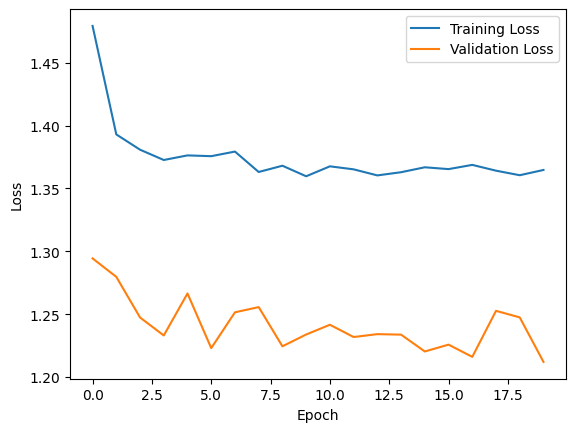

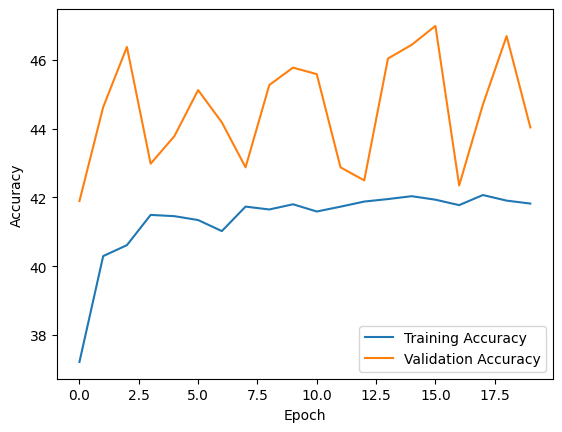

In [15]:
trainset = MelSpectrogramDataset(
    csv_file=train_csv, root_dir=root_dir, transform=transform)
valset = MelSpectrogramDataset(
    csv_file=val_csv, root_dir=root_dir, transform=transform)
testset = MelSpectrogramDataset(
    csv_file=test_csv, root_dir=root_dir, transform=transform)

trainloader = DataLoader(trainset, batch_size=128,
                         shuffle=True, num_workers=8, pin_memory=True)
valloader = DataLoader(valset, batch_size=128,
                       shuffle=False, num_workers=8, pin_memory=True)
testloader = DataLoader(testset, batch_size=128,
                        shuffle=False, num_workers=8, pin_memory=True)

# Label mappings
labelmap = trainset.label_map
print(f"Mapping from Emotion to Number: {labelmap}")

print(f"Model is on: {next(model.parameters()).device}")
model, train_losses, train_accuracies, val_losses, val_accuracies = train_epochs(
    model, trainloader, valloader, criterion, optimizer, device, epochs)
torch.save(model.state_dict(), f'{FINETUNED_MODEL}_variables_{epochs}.pt')

# Plots
plot_loss(train_losses, val_losses)
plot_accuracy(train_accuracies, val_accuracies)

Define the function to plot the confusion matrix


In [16]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(y_true, y_pred):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create figure and axes
    plt.figure(figsize=(10, 8))

    # Create heatmap
    sns.heatmap(cm,
                annot=True,  # Show numbers in cells
                fmt='d',     # Use integer formatting
                cmap='Blues',  # Color scheme
                xticklabels=trainset.label_map.keys(),
                yticklabels=trainset.label_map.keys())

    # Set labels and title
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')

    # Rotate axis labels for better readability
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)

    plt.tight_layout()
    plt.show()

Define the function to evalaute best model on test set


In [17]:
def get_predictions(model, testloader, device, model_path):
    # Load the best model weights
    model.load_state_dict(torch.load(model_path))
    model.eval()

    all_preds = []
    all_labels = []
    print("Evaluating best model on test set...")

    with torch.no_grad():
        for inputs, labels in tqdm(testloader, desc='Testing'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            # Store predictions for confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

Define the function to print out the evaluation metrics


In [18]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report


def get_evaluation_metrics(true_labels, pred_labels, label_map):
    # Compute metrics
    accuracy = accuracy_score(true_labels, pred_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, pred_labels, average='weighted')

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1-score: {f1:.4f}\n")

    # Print detailed classification report
    print(classification_report(true_labels, pred_labels,
          target_names=list(label_map.keys())))

Evaluate the best model on the test set


C:\Users\profi\AppData\Local\Temp\ipykernel_6468\3256607076.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Evaluating best model on test set...


Testing: 100%|██████████| 75/75 [00:26<00:00,  2.83it/s]

Test Accuracy: 0.4564
Test Precision: 0.5265
Test Recall: 0.4564
Test F1-score: 0.4234

              precision    recall  f1-score   support

       Anger       0.37      0.71      0.49       916
       Bored       0.60      0.77      0.67      1098
     Disgust       0.44      0.40      0.42       291
        Fear       0.19      0.69      0.30       308
       Happy       0.67      0.11      0.18      1914
     Neutral       0.55      0.26      0.35      2226
    Question       0.48      0.75      0.58      1139
         Sad       0.50      0.50      0.50       857
    Surprise       0.47      0.59      0.52       728

    accuracy                           0.46      9477
   macro avg       0.47      0.53      0.45      9477
weighted avg       0.53      0.46      0.42      9477



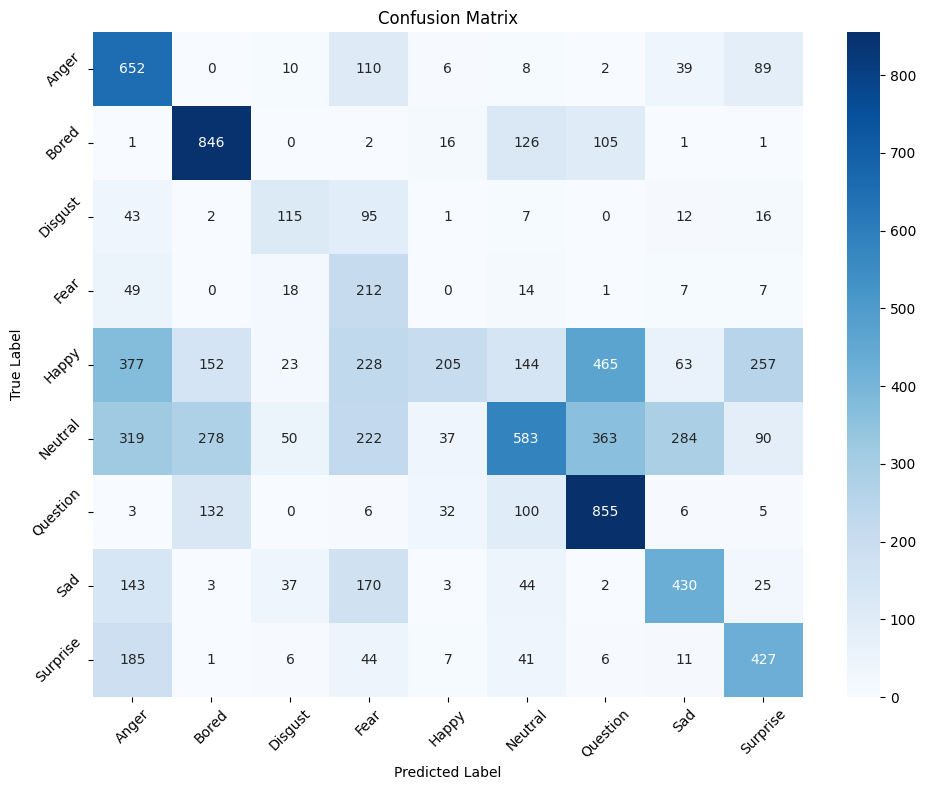

In [19]:
# Load and get predictions from the bets model
best_model_path = f'best_{FINETUNED_MODEL}.pt'
all_preds, all_labels = get_predictions(
    model=model,
    testloader=testloader,
    device=device,
    model_path=best_model_path
)

# Print detailed evaluation metrics
get_evaluation_metrics(all_labels, all_preds, labelmap)

# Plot confusion matrix
plot_confusion_matrix(all_labels, all_preds)